# Setup

In [2]:
import os
'''
Initial setup
'''
project_id = ''
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive")

    base_drive = 'Shared drives/Columbia Eyetracking Data/'
    data_dir = 'data/'
    os.chdir(base_drive)
elif not IN_COLAB:
    root_data_dir = '/home/jupyter/nsf-neurogesture/data_drive_sync'
    
    # 1. install command: curl https://rclone.org/install.sh | sudo bash
    # 2. follow instructions to set up credentials, use remote login in last step: https://rclone.org/drive/
    # !rclone sync nsf_neurogesture:data {root_data_dir} -P
    !rclone copy nsf_neurogesture:data {root_data_dir} -P

Transferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:                 2 / 2, 100%
Elapsed time:         0.0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:                 2 / 2, 100%
Elapsed time:         0.0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:                14 / 14, 100%
Elapsed time:         0.0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:                74 / 74, 100%
Elapsed time:         0.0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:               191 / 191, 100%
Elapsed time:         0.0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:               191 / 191, 100%
Elapsed time:         0.0sTransferred:   	         0 / 0 Bytes, -, 0 Bytes/s, ETA -
Checks:               210 / 210, 100%
Elapsed time:         0.0s


In [11]:
curr_run = '10-5'
curr_dir = root_data_dir+ '/processed_data/'+curr_run + '/'

In [3]:
#!pip install tensorflow-gpu
#!pip install -U scikit-learn
#!kill -9 -1
# Load the TensorBoard notebook extension
#%load_ext tensorboard
import sys
import numpy as np
import pickle
import pandas as pd
import datetime
import os
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, BatchNormalization, LeakyReLU, concatenate, Input, LSTM, Masking, Dense, TimeDistributed, Bidirectional, Activation, Embedding, Dropout
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


tf.keras.backend.clear_session()
print(tf.version)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print(tf.DeviceSpec(device_type="GPU", device_index=34343))
    gpus = True
else:
    gpus = False
    print("Not using GPU version of TF")

<module 'tensorflow_core._api.v2.version' from '/opt/conda/lib/python3.7/site-packages/tensorflow_core/_api/v2/version/__init__.py'>
Num GPUs Available:  0
Not using GPU version of TF


# Load Data

The dimensions:  ('vid_type-topic-pp-block', 'block', 'feature')
The attributes:  Coordinates:
  * vid_type-topic-pp-block  (vid_type-topic-pp-block) <U24 'full-tarmac-a2-1' ... 'single-perspective-z2-19'
  * block                    (block) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51
  * feature                  (feature) <U26 'fixation_start' ... 'blink_start_diff'
The features:  <xarray.DataArray 'feature' (feature: 19)>
array(['fixation_start', 'fixation_duration', 'fixation_xAvg', 'fixation_yAvg',
       'fixation_pupilAvg', 'fixation_start_diff', 'fixation_xAvg_diff',
       'fixation_yAvg_diff', 'fixation_aoi', 'saccades_start',
       'saccades_duration', 'saccades_xEnd_minus_xStart',
       'saccades_yEnd_minus_yStart', 'saccades_ampDeg', 'saccades_vPeak',
       'saccades_start_diff', 'blink_start', 'blink_duration',
       'blink_start_diff'], dtype='<U26')
Coordinates:
    vid_type-topic-pp-block  <U24 'full-bicycle-g3-1'
  * feature                  (feature) <U26 'fixation_

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


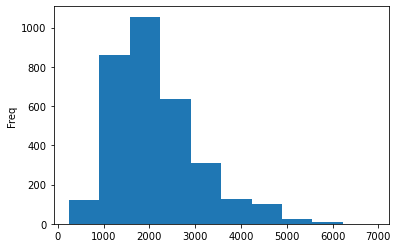

In [13]:
var_to_exclude = ['fixation_pupilAvg']
loss = 'mean_squared_error'
early_stopping_loss = loss
final_activation='relu'
batch_size = 32
epochs = 5000
optimizer = tf.optimizers.Adam(lr=0.0001)
#optimizer = tf.train.AdamOptimizer(0.001)
output_scaling = False
output_limit = False
filter_by_mean = False

dataset = pd.read_pickle(curr_dir+'processed_tensor.pkl')
labels = np.load(curr_dir+'labels.npy')
scaler = StandardScaler() # use the same scaler for all X
lb = LabelEncoder()
#imp_mean = SimpleImputer(missing_values=np.float(-999), strategy='mean')
if output_scaling:
  output_scaler = MinMaxScaler()
  labels = output_scaler.fit_transform(labels.reshape(-1, 1))
  labels = labels.reshape(-1)

%matplotlib inline
plt.hist(labels)
plt.ylabel('Freq');

print('The dimensions: ', dataset.dims)
print('The attributes: ', dataset.coords)
print('The features: ', dataset['feature'].values)
#print('One sample: ', dataset.loc['full-bicycle-g3-1'])

In [14]:
def filter_training(cond):
  accuracy_csv = pd.read_csv('../accuracy_measures.csv')
  accuracy_csv = accuracy_csv.applymap(lambda s:s.lower() if type(s) == str else s)
  keys_arr = list(dataset.keys())
  keys_arr = list(map(lambda x: x.split('-') , keys_arr))
  if cond == 'overall_2_bins':
    average_dict = {
      'bicycle': 'BQAVG',
        'perspective': 'PQAVG',
        'tarmac': 'TQAVG'
    }
    mid_point = np.mean(pd.concat([accuracy_csv['TQAVG'],accuracy_csv['PQAVG'],accuracy_csv['BQAVG']]))
    print('splitting each sequence based on the mean of overall accuracy. each participant will belong to a higher or lower category depending on their overall accuracy > or < : ', mid_point)
    output = []
    for key in keys_arr:
      output.append(float(accuracy_csv[(accuracy_csv.ParticipantID == key[2]) & (accuracy_csv.Condition == key[0])][average_dict[key[1]]]))
    greater_than = [i for i,v in enumerate(output) if v > mid_point]
    bins_output = []
    for num in range(len(output)):
      if num in greater_than:
        bins_output.append(2)  # greater than mid point
      else:
        bins_output.append(1)
  return bins_output

# Define Processing Functions

In [15]:
def data_prep(dataset, labels, feature_list, cat_idx, num_idx):
    if output_limit:
      #labels = np.where(labels > np.float32(-1000), labels, np.nan)
      #labels = np.where(labels < np.float32(1000), labels, np.nan)
      labels = labels + np.absolute(np.min(labels))
    if filter_by_mean:
      bins_return = filter_training('overall_2_bins')  # split data by overall average
      greater_than = [i for i,v in enumerate(bins_return) if v == 2]
      lesser_than = [i for i,v in enumerate(bins_return) if v == 1]
      labels = labels[greater_than]
      dataset = dataset.iloc[greater_than]
    # mask labels that are nan
    index = ~np.isnan(labels)
    labels = labels[index]
    mask = np.ones(len(dataset), dtype=bool)
    mask = index
    dataset = dataset[mask,]
    %matplotlib inline
    plt.hist(labels)
    plt.ylabel('Freq');
    plt.show()
    dataset_keys = dataset['vid_type-topic-pp-block'] # for lookup later
    dataset = dataset.values
    #encode AOI, will need to be modified if more categoricals are added later
    lb.fit(['i','t','p','nan'])
    print('aoi labels: ', lb.classes_)
    for pp in range(dataset.shape[0]):
        thiscol = dataset[pp,:,cat_idx[0]].astype(str)
        dataset[pp,:,cat_idx[0]] = lb.transform(thiscol)
    # ensure all data is float
    values = dataset.astype('float32')

    # isolate numerical features (refernce: https://stackoverflow.com/questions/52627739/how-to-merge-numerical-and-embedding-sequential-models-to-treat-categories-in-rn)
    num_cats = len(cat_idx)  # number of categorical features
    n_steps = values.shape[1]  # number of timesteps in each sample
    n_numerical_feats = len(num_idx)  # number of numerical features in each sample
    cat_embd_dim = [50]  # embedding dimension for each categorical feature, for now just AOI
    numerical_input = Input(shape=(n_steps, n_numerical_feats), name='numeric_input')
    cat_inputs = []
    cat_size = []
    for i in range(num_cats):
        cat_inputs.append(Input(shape=(n_steps,), name='cat' + str(i + 1) + '_input'))
        cat_size.append(len(lb.classes_))  # number of categories in each categorical feature

    cat_embedded = []
    for i in range(num_cats):
        embed = Embedding(cat_size[i], cat_embd_dim[i])(cat_inputs[i])
        cat_embedded.append(embed)
        pass
        
    # impute
    si =  SimpleImputer(missing_values=np.nan, strategy='mean')
    for i in range(len(num_idx)):
        feat_mean = np.nanmean(values[:,:,num_idx[i]])
        for pp in range(values.shape[0]):
            imputed = si.fit_transform(values[pp,:,num_idx[i]].reshape(-1,1))
            if imputed.shape[1] == 0:
                values[pp,:,num_idx[i]] = feat_mean # fill with feature mean
            else:    
                values[pp,:,num_idx[i]] = np.squeeze(imputed)
    X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(values,
                                                        labels,range(len(dataset)),
                                                        test_size=0.20)
    return (X_train, X_test, y_train, y_test, numerical_input, cat_embedded, 
            cat_inputs, dataset_keys[indices_train], dataset_keys[indices_test])

def scale_x(x):
    # reshape values
    nsamples, nx, num_features = x.shape
    values = np.reshape(x, (-1, num_features))
    values = np.where(values==np.nan, 0, values)
    #values = imp_mean.fit_transform(values)
    scaled = scaler.fit_transform(values)
    scaled = np.reshape(scaled, (nsamples, nx, num_features))
    return scaled

def scale_x_test(x):
    # reshape values
    nsamples, nx, num_features = x.shape
    values = np.reshape(x, (-1, num_features))
    values = np.where(values==np.nan, 0, values)
    #values = imp_mean.transform(values)
    scaled = scaler.transform(values)
    scaled = np.reshape(scaled, (nsamples, nx, num_features))
    return scaled

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred))
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true)))
    return (1 - SS_res/(SS_tot + backend.epsilon()))

# LSTM Architecture with AOI Embeddings

In [16]:
def vanilla_lstm(run_no, X_train, y_train, X_test, y_test, numerical_input, cat_embedded, cat_inputs, num_idx, cat_idx, n_steps):
    # define the checkpoint
    filepath = curr_dir+str(run_no)+'/'+'model.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    earlystopping = EarlyStopping(monitor=early_stopping_loss, patience=500, verbose=1, mode='auto')
    log_loc = curr_dir+str(run_no)+'/'+"./logs"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_loc, histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True,
                         update_freq = 'epoch')
    callbacks_list = [checkpoint, earlystopping, tensorboard_callback]
    cat_merged = cat_embedded[0]  # can be another concatenate if more than one categorical
    merged = concatenate([numerical_input, cat_merged])
    x = (Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))(merged)
    x = BatchNormalization()(x)
    x = (Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))(x)
    x = BatchNormalization()(x)
    x = (Dense(units=1, activation=final_activation))(x)
    model = Model(inputs=[numerical_input] + cat_inputs, outputs=x)
    model.summary()
    
    X_tr_numerical = scale_x(X_train[:, :, num_idx])
    X_te_numerical = scale_x_test(X_test[:, :, num_idx])

    
    X_tr_cat1 = np.squeeze(X_train[:, :, cat_idx], axis=2)
    X_te_cat1 = np.squeeze(X_test[:, :, cat_idx], axis=2)
    model.compile(
          optimizer=optimizer,
          loss=loss,
          metrics=[loss, rmse, r_square]
      )
    # inline tensorboard (more limited)
    #%tensorboard --logdir logs --port=6006
    result = model.fit({
          'numeric_input': X_tr_numerical,
          'cat1_input': X_tr_cat1},
          y_train, 
          epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks_list)
    model.evaluate({'numeric_input': X_te_numerical,
               'cat1_input': X_te_cat1},
               y_test)
    # get predictions
    y_pred = model.predict({'numeric_input': X_te_numerical,
               'cat1_input': X_te_cat1})
    with open(curr_dir+str(run_no)+'/'+'training_history.pkl', 'wb') as file_pi:
        pickle.dump(result.history, file_pi)

# Plot Results each Run 

In [17]:
def load_existing_model(load_model_path, result_path, X_train, y_train, X_test, y_test, numerical_input, cat_embedded, cat_inputs,
                        num_idx, cat_idx, n_steps):
    X_tr_numerical = scale_x(X_train[:, :, num_idx])
    X_te_numerical = scale_x_test(X_test[:, :, num_idx])
    # extract categorical features: you can use a for loop to this as well.
    # note that we reshape categorical features to make them consistent with the updated solution
    X_tr_cat1 = np.squeeze(X_train[:, :, cat_idx], axis=2)
    X_te_cat1 = np.squeeze(X_test[:, :, cat_idx], axis=2)

    model = tf.keras.models.load_model(load_model_path, custom_objects={'rmse': rmse, 'r_square': r_square})
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[loss, rmse, r_square]
    )
    model.evaluate({'numeric_input': X_te_numerical,
                                 'cat1_input': X_te_cat1},
                                y_test)
    # get predictions
    y_pred = model.predict({'numeric_input': X_te_numerical,
                            'cat1_input': X_te_cat1})
    if output_scaling:
      y_pred = output_scaler.inverse_transform(y_pred)
      y_test = output_scaler.inverse_transform(y_test)
    # -----------------------------------------------------------------------------
    # Plot learning curves including R^2 and RMSE
    # -----------------------------------------------------------------------------
    if os.path.exists(result_path):
      result = pickle.load( open(result_path, "rb" ) )
      # plot training curve for R^2 (beware of scale, starts very low negative)
      plt.plot(result['val_r_square'])
      plt.plot(result['r_square'])
      plt.title('model R^2')
      plt.ylabel('R^2')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.show()

      # plot training curve for rmse
      plt.plot(result['rmse'])
      plt.plot(result['val_rmse'])
      plt.title('rmse')
      plt.ylabel('rmse')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.show()
    
    # print the linear regression and display datapoints
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(y_test.reshape(-1, 1), y_pred)
    y_fit = regressor.predict(y_pred)

    reg_intercept = round(regressor.intercept_[0], 4)
    reg_coef = round(regressor.coef_.flatten()[0], 4)
    reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

    plt.scatter(y_test, y_pred, color='blue', label='data')
    plt.plot(y_pred, y_fit, color='red', linewidth=2, label='Linear regression\n' + reg_label)
    #plt.ylim(1913.95, 1913.96)
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('observed')
    plt.ylabel('predicted')
    plt.show()
    
    return y_pred

# Train 10 Times and Plot Predicted Test Sample Pupil Diameters

In [ ]:
def model_runs(run_num=10):
    feature_list = list(dataset['feature'].values)
    categorical_var_list = ['fixation_aoi']
    mask_categorical_outcome = list(categorical_var_list)
    mask_categorical_outcome.extend(var_to_exclude)
    cat_idx = [feature_list.index(cat) for cat in categorical_var_list]
    num_vars_list = [i for i in feature_list if i not in mask_categorical_outcome]
    num_idx = [feature_list.index(num) for num in num_vars_list]
    for i in range(run_num):
        if not os.path.exists(str(i)):
            os.makedirs(str(i))
        X_train, X_test, y_train, y_test, numerical_input, cat_embedded, cat_inputs, train_keys, test_keys= data_prep(dataset, labels, feature_list, cat_idx, num_idx)
        if not os.path.exists(str(i)+'/'+'model.h5'):
            with open(str(i)+'/'+'saved_data.pkl', 'wb') as f:
                pickle.dump([X_train, y_train, X_test, y_test, num_idx, cat_idx, train_keys, test_keys], f)
            vanilla_lstm(i, X_train, y_train, X_test, y_test, numerical_input, cat_embedded, cat_inputs, num_idx, cat_idx, n_steps=dataset.shape[1]) 
        else:
          if os.path.exists('saved_data.pkl'):
            with open(str(i)+'/'+'saved_data.pkl', 'rb') as f:
              X_train, y_train, X_test, y_test, num_idx, cat_idx, train_keys, test_keys = pickle.load(f)
              # to test for whether model is doing anything
              #np.random.shuffle(y_test)
        y_pred = load_existing_model(str(i)+'/'+'model.h5',str(i)+'/'+'training_history.pkl', X_train, y_train, X_test, y_test, numerical_input, cat_embedded, cat_inputs, num_idx, cat_idx, n_steps=dataset.shape[1])
        print('done')

model_runs(run_num=10)